# NLP Text Extraction

##### Step 4: Use Spacy Natural Language Processing to parse formatted text. 
Finding Date and Total: Text can be parsed using Regular Expressions. Create multiple spacy ‘Patterns’ to catch when parsing. 
Finding Expense Type: 
<ul>
<li>Approach 1: Load Spacy’s preloaded semantic vocabulary. Calculate the average word vector for the purchased items. Find which category(‘Food’, ‘Parking’, “Gas”) the average word vector has the least distance to.</li>
<li>Approach 2: Create a classifier (Naive Bayes, SVM, DTrees, etc) that classifies the text of common receipt types. Requires the dataset to be labelled by type. Receipt text will need to be vectorized using Scikit Learn before use of machine learning. </li>
<li>Approach 3: Ensemble Approach; use a combination of models and vector calculations to classify expense type. (Typically leads to the highest accuracy)</li>
</ul>

#### Imports

In [6]:
# Import Standard Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

In [7]:
# Import Spacy
import re
import string
import spacy
from spacy import displacy
# Prereq: python -m spacy download en_core_web_lg
nlp = spacy.load('en_core_web_lg')

In [13]:
# Import NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /Users/DJ/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /Users/DJ/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Experimentiation

In [14]:
tokens = nlp(u'dog cat banana afskfsd')

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov, token.pos_)

dog True 7.0336733 False NOUN
cat True 6.6808186 False NOUN
banana True 6.700014 False NOUN
afskfsd False 0.0 True VERB


In [15]:
nlp('dog')[0].pos_

'NOUN'

In [16]:
sample = nlp("Car Rental")
# Sample Word Vector
print(sample)
print(len(sample.vector))
sample.vector

Car Rental
300


array([ 0.24232501,  0.38059002, -0.08118699, -0.25529552,  0.7986    ,
       -0.36277002, -0.0828815 , -0.31675   ,  0.07677999,  2.2633    ,
       -0.50778997,  0.15125   , -0.0975915 ,  0.34356   , -0.76972   ,
       -0.307595  , -0.37683052,  1.8129001 ,  0.30364   , -0.253775  ,
        0.124118  , -0.124935  ,  0.39578652,  0.1018555 ,  0.00731795,
        0.253406  , -0.087625  , -0.34978002,  0.11619814,  0.41590002,
        0.497665  , -0.43941498,  0.046311  ,  0.89322996, -0.281405  ,
       -0.28235   ,  0.11944   ,  0.155499  , -0.262685  ,  0.213545  ,
        0.3018035 , -0.10932501,  0.068349  ,  0.08955   , -0.1122165 ,
        0.241071  ,  0.38379598, -0.47051   ,  0.51219   , -0.0819481 ,
        0.0576755 , -0.68233   ,  0.037156  ,  0.23936   ,  0.04844001,
       -0.140009  ,  0.136055  , -0.41298   ,  0.02999   , -0.10543   ,
        0.22964   , -0.16194999,  0.1374385 ,  0.47698   ,  0.22884001,
       -0.017768  ,  0.05226515,  0.21176551, -0.02549   ,  0.26

In [17]:
test = ['dog', 'cat', 'banana', 'afskfsd']

### Text Formatting and Cleaning

In [18]:
stop = 'Cash Change Register VISIT OUR WEBSITE THANKS FOR YOUR VISIT PLEASE TAKE OUR SURVEY SEE BACK FOR DETAILS TAX CASH TENDERED CHANGE order Come Again rewards total coupon rebate subtotal visa emp id invalid'

In [19]:
print(list(set(stop.lower().split())))

['change', 'website', 'order', 'tendered', 'for', 'thanks', 'invalid', 'survey', 'our', 'take', 'total', 'rebate', 'visit', 'visa', 'details', 'back', 'subtotal', 'again', 'your', 'rewards', 'id', 'cash', 'come', 'emp', 'coupon', 'register', 'tax', 'please', 'see']


In [20]:
# Remove Punctuation
# param text (arr) - Text to Clean
def remove_punc(text):
    return re.sub(r'[^\w\s]','',text)

# Remove Words that are Numbers from a List
# param text (arr) - List of Words
def remove_num(text):
    return [w for w in text if not w.isdigit()]

# Tokenize Words
# param text (arr) - List of Words
def tokenize_words(text):
    return word_tokenize(' '.join(text))

# Remove Stop Words
# param text (arr) - List of Words
def remove_stop(text):
    stop_words = set(stopwords.words('english'))
    return [w for w in text if not w in stop_words]

# Remove Custom Stop Words
# param text (arr) - List of Words
def remove_custom_stop(text):
    custom_stop_words = ['visit', 'back', 'visa', 'change', 'thanks', 'survey', 'total', 'tax',
                         'coupon', 'invalid', 'details', 'your', 'emp', 'rewards', 'please',
                         'see', 'register', 'order', 'take', 'again', 'our', 'subtotal', 'for',
                         'rebate', 'cash', 'website', 'id', 'come', 'tendered', 'building', 'street']
    return [w for w in text if not w in custom_stop_words]

# Filter for only Nouns
# param text (arr) - List of Words
def remove_non_nouns(text):
    return [w for w in text if nlp(w)[0].pos_ == 'NOUN']

# Remove Meaningless Words
# param text (arr) - List of Words
# param report (bool) - Print Number of Removed Words
def remove_meaningless(text, report=True):     
    cleaned = [w for w in text if not nlp(w).vector_norm == 0]
    if report: print('Removed ' + str(len(text) - len(cleaned)) + ' word(s) out of ' + str(len(text)))
    return cleaned
    

# Extrats Text from the Formatted Text Output of Azure Text Detection
# param text_id (str) - ID of the text
def extract_text(text_id):
    file = open('text/' + str(text_id) +'.txt', 'r')
    text = file.readlines()
    words = []
    for i in text:
        word = i.split(':')[-1].split('}')[0].strip()
        word = remove_punc(word)
        if word != '': words.append(word.lower())
    return words

# Extract and Clean Text
# param text_id (str) - ID of the text
def format_text(text_id):
    text = extract_text(text_id)
    print(text)
    text = remove_num(text)
    text = tokenize_words(text)
    text = remove_stop(text)
    text = remove_custom_stop(text)
    text = remove_meaningless(text)
    return text

### Word Vector (TSNE) Visualization

In [11]:
from sklearn.manifold import TSNE

import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [12]:
# Reduce the Dimensionality of the Word Embeddings
# Uses Preloaded Spacy Vectors
# param text (arr) - List of Words
def tsne_fit(text, dim=2):
    tokens = [nlp(w).vector for w in text ]
    tsne_model = TSNE(perplexity=40, n_components=dim, init='pca', n_iter=2500, random_state=23)
    return tsne_model.fit_transform(tokens)

# Conduct TSNE on Types and Additional Text
# param types (arr) - List of Categories
# param text (arr) - List of Additional words
# return types (arr), text (arr) - post-TSNE Values
def types_text_tsne(types, text, dim=2):
    tokens = tsne_fit(types + text, dim=dim)
    return tokens[:len(types)], tokens[len(types):]

In [13]:
# 2D Plot of Expense Types and Words (Word Embeddings)
# param types (arr) - Classification Types
# param text (arr) - Additional Words
# param avg_vect (bool) - Whether the average word vector should be plotted
def tsne_plot_2d(types, text=None, avg_vect=False):
    
    title='Types and Words'
    # Get the Reduced TSNE Values
    types_arr_2d = tsne_fit(types, dim=2) 
    text_arr_2d = []
    if text: 
        types_arr_2d, text_arr_2d = types_text_tsne(types, text, dim=2)
        title='Types'
        
    x,y = np.array(types_arr_2d).transpose()

    trace1 = go.Scatter(
        x=x,
        y=y,
        marker=dict(
            size=5,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=0.8
        ),
        mode='markers+text',
        name='Types',
        text= types,
        textposition='top right',
        textfont=dict(
            family='sans serif',
            size=12,
            color='#1f77b4'
        )
    )
    if text:
        x2,y2 = np.array(text_arr_2d).transpose()
        trace2 = go.Scatter(
            x=x2,
            y=y2,
            marker=dict(
                color='rgb(127, 127, 127)',
                size=5,
                symbol='circle',
                line=dict(
                    color='rgb(204, 204, 204)',
                    width=1
                ),
                opacity=0.9
            ),
            mode='markers+text',
            name='Words',
            text= text,
            textposition='top right',
            textfont=dict(
                family='sans serif',
                size=12,
                color='rgb(127, 127, 127)'
            )
        )
    
    if text and avg_vect:
        x3,y3 = [], []
        avg_vector = np.average(np.array(text_arr_2d).transpose(), axis=1)
        x3.append(avg_vector[0])
        y3.append(avg_vector[1])
        trace3 = go.Scatter(
            x=x3,
            y=y3,
            marker=dict(
                color='rgb(220, 20, 60)',
                size=7,
                symbol='circle',
                line=dict(
                    color='rgb(220, 20, 60)',
                    width=1
                ),
                opacity=0.9
            ),
            mode='markers+text',
            name='Average Word Vector',
            text= ['AVG VECTOR'],
            textposition='top right',
            textfont=dict(
                family='sans serif',
                size=12,
                color='rgb(220, 20, 60)'
            )
        )

        
    # Include Trace Into Data Variable
    data = [trace1]
    if text and not avg_vect: data = [trace1, trace2]
    elif text and avg_vect: data = [trace1, trace2, trace3]
        
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    layout = go.Layout(
        title='Types'
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='types-and-words')

In [14]:
# 3D Plot of Expense Types and Words (Word Embeddings)
# param types (arr) - Classification Types
# param text (arr) - Additional Words
# param avg_vect (bool) - Whether the average word vector should be plotted
def tsne_plot_3d(types, text=None, avg_vect=False):
    
    title='Types and Words'
    # Get the Reduced TSNE Values
    types_arr_2d = tsne_fit(types, dim=3) 
    text_arr_2d = []
    if text: 
        types_arr_2d, text_arr_2d = types_text_tsne(types, text, dim=3)
        title='Types'
        
    x,y,z = np.array(types_arr_2d).transpose()
    trace1 = go.Scatter3d(
        x=x,
        y=y,
        z=z,
        marker=dict(
            size=5,
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=0.8
        ),
        mode='markers+text',
        name='Types',
        text= types,
        textposition='top right',
        textfont=dict(
            family='sans serif',
            size=12,
            color='#1f77b4'
        )
    )
    if text:
        x2,y2,z2 = np.array(text_arr_2d).transpose()
        trace2 = go.Scatter3d(
            x=x2,
            y=y2,
            z=z2,
            marker=dict(
                color='rgb(127, 127, 127)',
                size=5,
                symbol='circle',
                line=dict(
                    color='rgb(204, 204, 204)',
                    width=1
                ),
                opacity=0.9
            ),
            mode='markers+text',
            name='Words',
            text= text,
            textposition='top right',
            textfont=dict(
                family='sans serif',
                size=12,
                color='rgb(127, 127, 127)'
            )
        )
        
    if text and avg_vect:
        x3,y3, z3 = [], [], []
        avg_vector = np.average(np.array(text_arr_2d).transpose(), axis=1)
        x3.append(avg_vector[0])
        y3.append(avg_vector[1])
        z3.append(avg_vector[2])
        trace3 = go.Scatter3d(
            x=x3,
            y=y3,
            z=z3,
            marker=dict(
                color='rgb(220, 20, 60)',
                size=7,
                symbol='circle',
                line=dict(
                    color='rgb(220, 20, 60)',
                    width=1
                ),
                opacity=0.9
            ),
            mode='markers+text',
            name='Average Word Vector',
            text= ['AVG VECTOR'],
            textposition='top right',
            textfont=dict(
                family='sans serif',
                size=12,
                color='rgb(220, 20, 60)'
            )
        )

    # Include Trace Into Data Variable
    data = [trace1]
    if text and not avg_vect: data = [trace1, trace2]
    elif text and avg_vect: data = [trace1, trace2, trace3]
        
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    layout = go.Layout(
        title=title
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig, filename='types-and-words')

### Similarity Matrix Visualization

In [21]:
# Finds the Most Similar Expense Type
# param types (arr) - List of Expense Types
# param text (arr) - Array of Text
def get_sim_matrix(types, text):
    sim_matrix = []
    for word in text:
        word_sim = []
        for exp_type in types: word_sim.append(nlp(word).similarity(nlp(exp_type)))
        sim_matrix.append(word_sim)
    return sim_matrix

# Plots a Heatmap of the Similarity Matrix
# param sim_matrix (arr 2d) - Contains similarities x=types, y=text
# param x_labels (arr) - Types
# param y_labels (arr) - Text
def plot_sim_matrix(sim_matrix, x_labels, y_labels):
    fig_height = max(5, round(5 * len(y_labels)/len(x_labels), 1))
    with sns.axes_style("white"):
        plt.figure(figsize=(5, fig_height))
        plt.title('Similarity Matrix - Words and Expense Types')
        ax = sns.heatmap(sim_matrix, vmax=1, vmin=0, cmap="Reds", xticklabels=x_labels, yticklabels=y_labels)
        plt.show()
        
# Calculate and Plots Sim Matrix
# param types (arr) - List of Expense Types
# param text (arr) - Array of Text
def calc_plot_sim_matrix(types, text):
    sim_matrix = get_sim_matrix(types, text)
    plot_sim_matrix(sim_matrix, types, text)

In [22]:
nlp('Coffee').similarity(nlp('Lunch'))

0.5666308575254905

### Categorization by Average Vector Functions

In [23]:
# Get the Avg Vector of Text
# param text (arr) - Text to Avg
# return avg_vect (arr) - Averaged Vector of Text
def avg_vect(text):
    return nlp(' '.join(text))

# Finds the Most Similar Expense Type
# param types (arr) - List of Expense Types
# param text (arr) - Array of Text
def most_similar_by_avg(types, text):
    avg_vector = avg_vect(text)
    closest_type = ''
    closest_score = 0
    for i in types:
        #print(str(round(avg_vector.similarity(nlp(i)), 2)) + ' ' + i)
        similarity = avg_vector.similarity(nlp(i))
        if(similarity > closest_score):
            closest_score = similarity
            closest_type = i
    closest_score = round(closest_score * 100, 3)
    return closest_type, closest_score  

# Plots Type Similarity Using the Avg Word Vector
# types (arr) - List of Expense Types
def plot_similar_by_avg(types, text, text_id=''):
    avg_vector = avg_vect(text)
    sim = []
    for i in types: sim.append(avg_vector.similarity(nlp(i)))
    sns.barplot(types, sim, alpha=0.9).set_xticklabels(types, rotation=90)
    plt.xlabel('Category')
    plt.ylabel('Similarity')
    plt.title('Similarities by Expense Types for Receipt '+ str(text_id))
    plt.show()

#### Load and Visualize Expense Types

In [24]:
expense_types = ['Airfare', 'Car Rental', 'Hotel', 'Fuel', 'Parking', 'Taxi', 'Toll', 'Train', 'Maintenance',
                 'Breakfast', 'Meal', 'Dinner', 'Lunch', 'Groceries', 'Coffee', 'Entertainment', 'Office Supplies', 'Software',
                 'Online Fees', 'Mobile', 'Cellular Phone']

In [25]:
tsne_plot_3d(expense_types, text, avg_vect=True)

NameError: name 'tsne_plot_3d' is not defined

#### Analyze Receipts

In [26]:
receipts_list = [18, 19, 24, 29, 33, 34, 36, 37, 38, 40, 42, 43, 45, 46, 50, 51, 52, 53]
short_list = [18, 19, 24, 29, 33, 34]

In [27]:
from PIL import Image
from IPython.display import HTML
from io import BytesIO
from base64 import b64encode

# Print Image into Notebook
# param path (str) - path to image
def display_img(path):
    pil_im = Image.open(path)
    b = BytesIO()  
    pil_im.save(b, format='png')
    display(HTML("<img src='data:image/png;base64,{0}' />".format(b64encode(b.getvalue()).decode('utf-8'))))

Analyzing Receipt #18



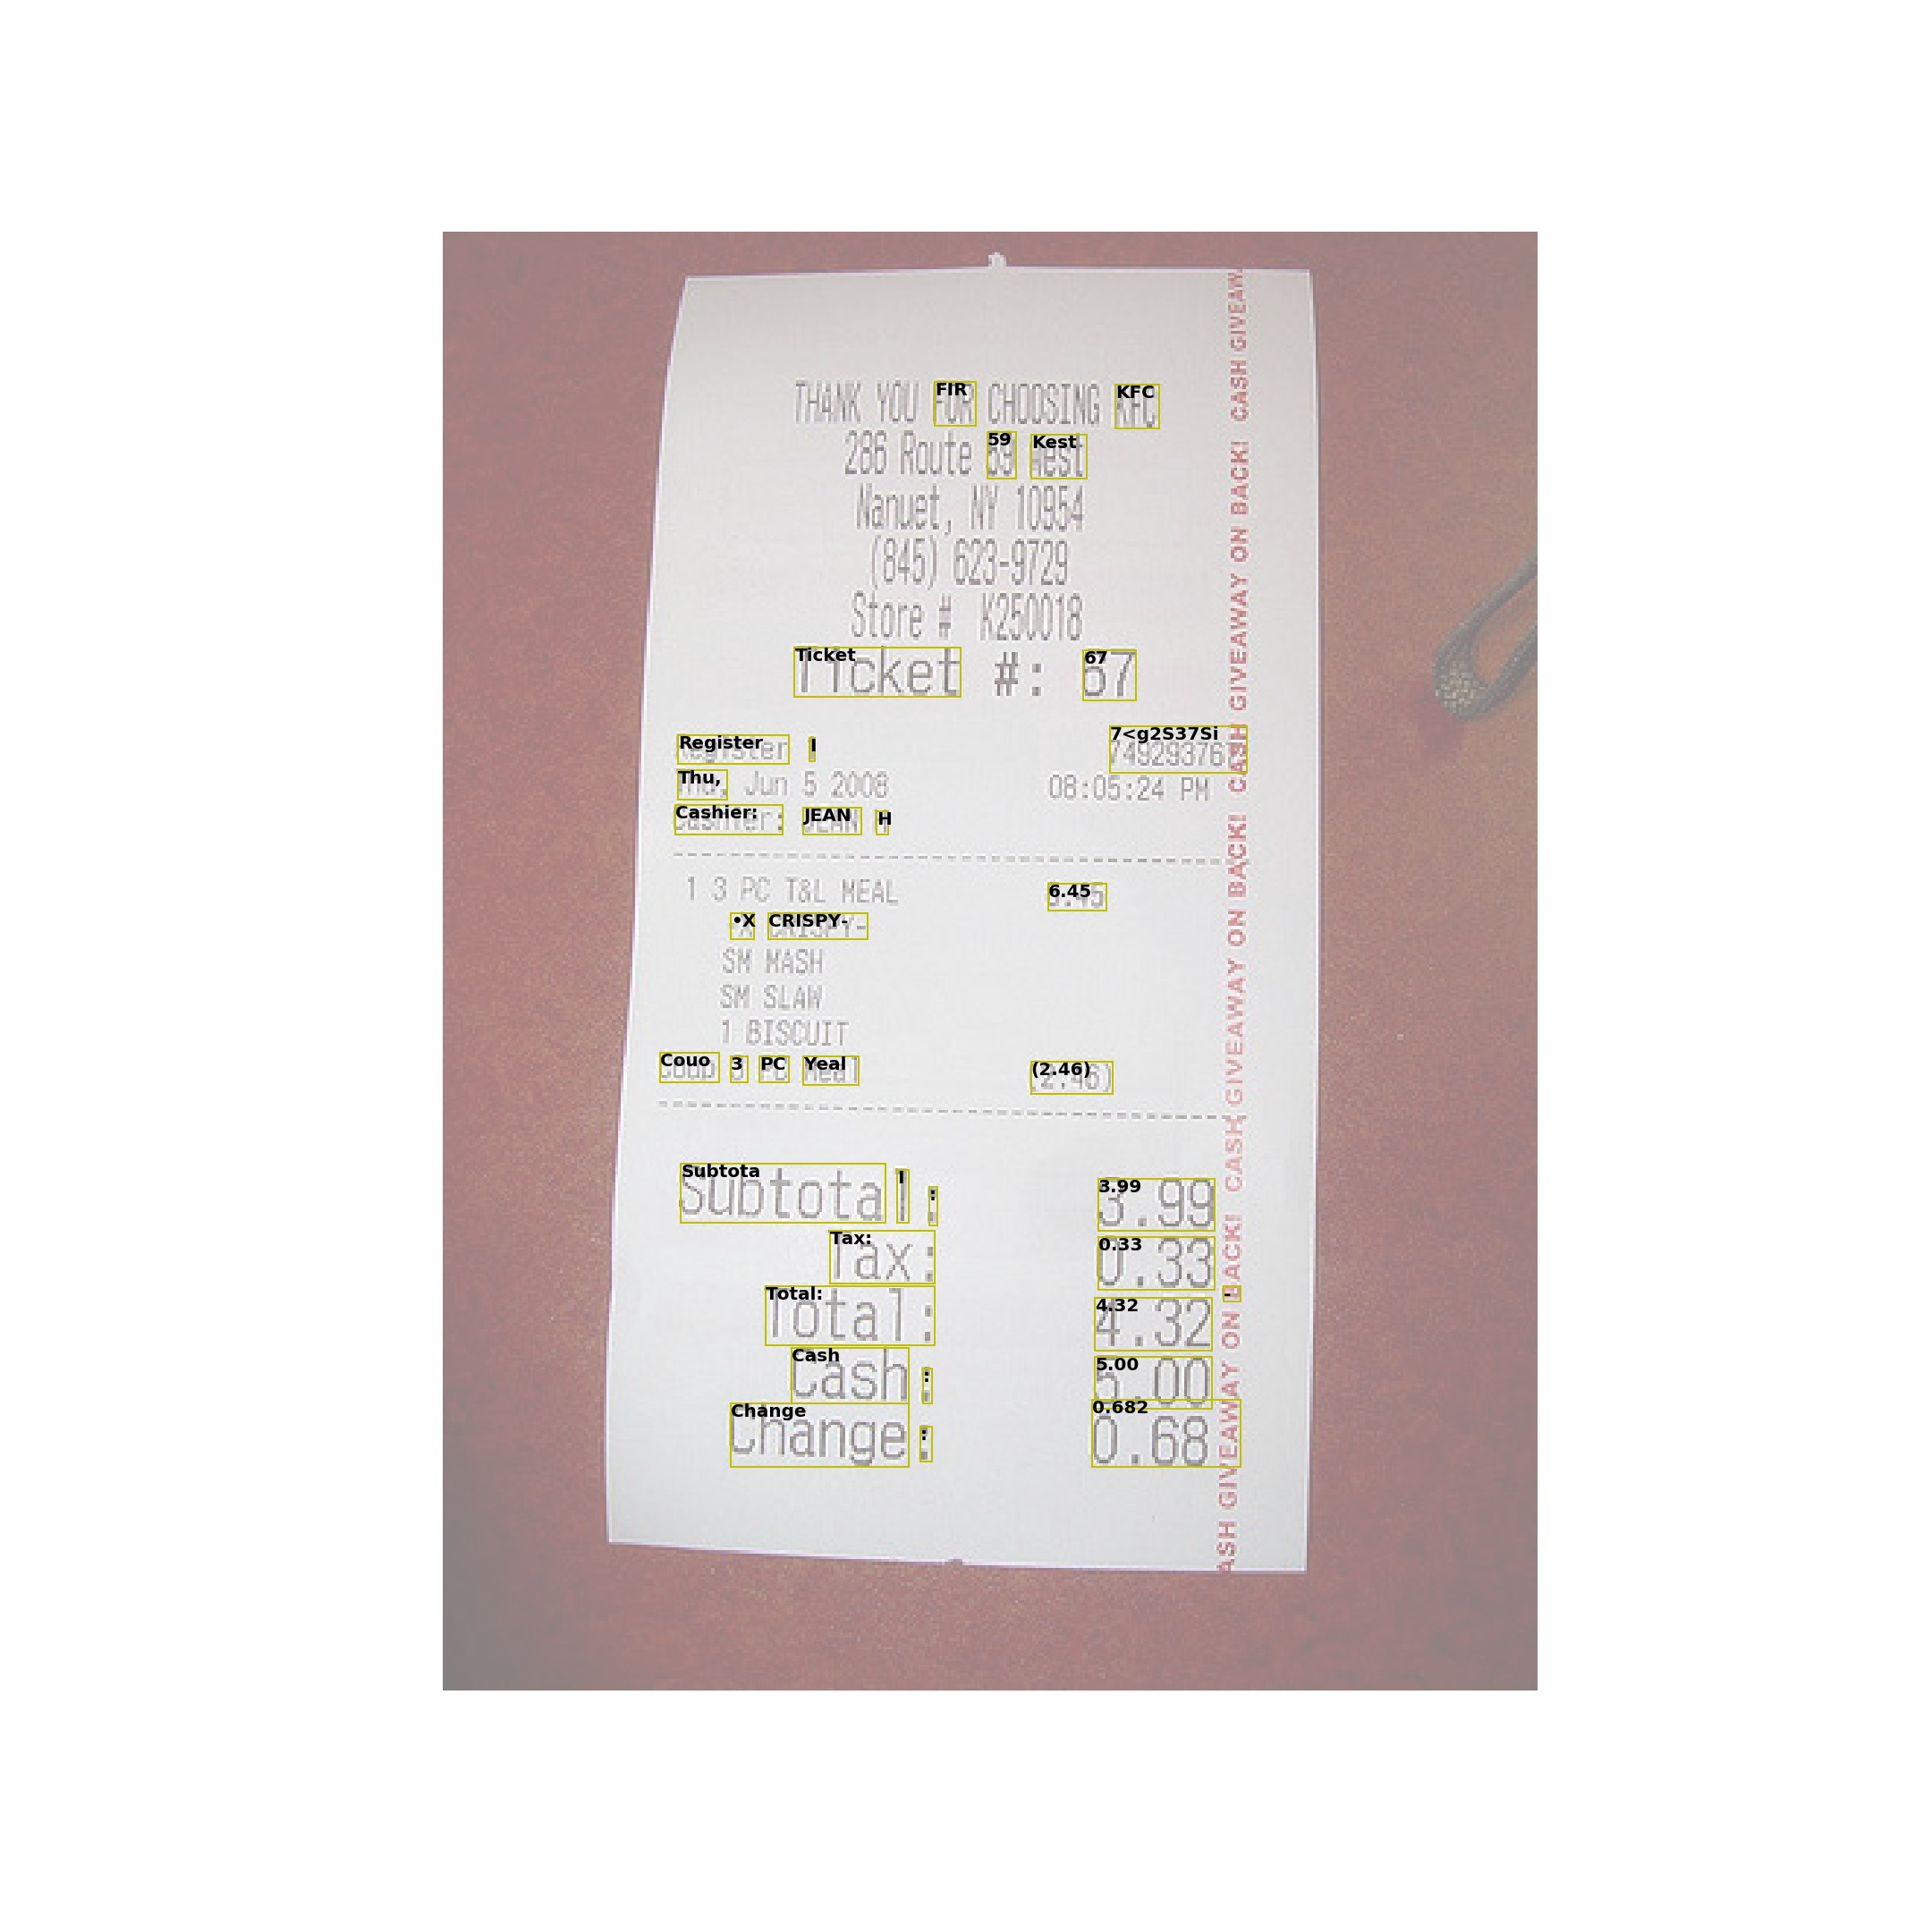

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x95 in position 584: invalid start byte

In [28]:
for i in receipts_list:
    print('Analyzing Receipt #' + str(i))
    display_img('img/' + str(i) + '.jpg')
    text = format_text(i)
    print(most_similar_by_avg(expense_types, text))
    print('TEXT: ' + ' '.join(text))
    tsne_plot_2d(expense_types, text, avg_vect=True)
    calc_plot_sim_matrix(expense_types, text)
    plot_similar_by_avg(expense_types, text, i)